# Tool for Determining Metabolite Profile Similarity

#### NOTE: Strict requirements for column inference. Information columns must have "peak id", "found m/z", "mass shift", "biotransformation", "r.t. (min)". Data columns must indicate the species (e.g. "human") and the method ("ms peak" or " uv").

In [1]:
compound = "SDPO-7159"
save_data = False
min_abundance = 0.1

species_flags = ('mouse', 'human', 'rat', 'dog', 'monkey')
method_flags = {'relative uv': '_uv', 'ms peak': '_ms',
                ' uv': '_uv'}
info_flags = {'rt min': 'ret_time', 'peak id': 'peak_id', 'biotransformation': 'modification',
              'found mz': 'mass', 'mass shift': 'mass_shift'}
replace_chars = {"\n": " ",    "(": " ",    ")": " ",    "\t": " ",    "#": " ",
                 ".": "",      "/": ""}

In [2]:
# Code to install python-docx:
# import sys
# !conda install --yes --prefix {sys.prefix} python-docx

import os
from docx import Document
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [3]:
met_id_flag = "Peak ID"
word_file_lut = {"TP-6755": Path("C:/Users/mlalonde/PycharmProjects/pythonProject/example_files/met_id_for_TP-6755.docx"),
                 "SDPO-7159": Path("Z:\Shared\Research and Development\Programs\RAD51\ADMET\Metabolite ID\Metabolite ID of SDPO-7159 in 5-species liver microsomes.docx"),
                 "TP-6379": Path("Z:\Shared\Research and Development\Programs\ALK5\ADMET\Metabolite ID\Met-ID report for TP-6379 5 species hepatocytes-20210430 (no password).docx")}

pdir = word_file_lut[compound].parents[0]
pdir.resolve()

WindowsPath('//EgnyteDrive/toleropharma/Shared/Research and Development/Programs/RAD51/ADMET/Metabolite ID')

In [4]:
def get_metabolite_dataframe(path):
    document = Document(path)
    # extract all tables from document
    raw_data = [[[cell.text.strip() for cell in row.cells] for row in table.rows] for table in document.tables]
    ascii_data = convert_to_ascii(raw_data)
    for table in ascii_data:
        if met_id_flag in table[0][0]:
            header, tvals1 = extract_headers(table)
            tvals2 = change_pattern_to_zero(tvals1, patterns=("--", "+", "ND"))
            tvals3 = drop_parent_rows(tvals2)
            return pd.DataFrame(data=tvals3, columns=header)

In [5]:
def convert_to_ascii(raw_data):
    """Takes a list of lists of lists and changes any non-readable characters to space."""
    converted_data = raw_data.copy()
    for t, table in enumerate(raw_data):
        for r, row in enumerate(table):
            for c, cell in enumerate(row):
                # detect a non-ascii character
                if not all(ord(char) < 128 for char in cell):
                    converted_data[t][r][c] = remove_non_ascii_chars(cell).strip()
    return converted_data

In [6]:
def remove_non_ascii_chars(input_string):
    """Utility for removing non-ascii characters from MS Word table text."""
    # This substitutes a space for any character with a unicode point > 126.
    return "".join([char if ord(char) < 126 else " " for char in input_string])

In [7]:
def extract_headers(raw_data, flag=None):
    if not flag:
        flag = raw_data[0][0]
    
    concat = raw_data[0]
    for i, row in enumerate(raw_data[1:]):
        if row[0] == flag:
            concat = [x + " " + y if x != y else x for x, y in zip (concat, row)]
        else: break
    return concat, raw_data[i+1:]

In [8]:
def change_pattern_to_zero(table, patterns):
    mod_table = list()
    for row in table:
        mod_table.append(["0.0" if cell in patterns else cell.strip("%") for cell in row])
    return mod_table

In [9]:
def drop_parent_rows(table):
    filtered = list()
    for row in table:
        if not any([flag in row[0] for flag in ('parent', 'Parent')]):
            filtered.append(row)
    return filtered

In [10]:
def clean_header_text(header_text):
    for old_char, new_char in replace_chars.items():
        header_text = header_text.replace(old_char, new_char)
    while "  " in header_text:
        header_text = header_text.replace("  ", " ")
    return header_text.strip().lower()

def get_col_label(header_text):
    ht_clean = clean_header_text(header_text)
    
    for key, val in info_flags.items():
        if key in ht_clean:
            return val
        
    for sp in species_flags:
        if sp in ht_clean:
            prefix = sp
            break

    for key, val in method_flags.items():
        if key in ht_clean:
            suffix = val
            break
    
    try:
        return prefix + suffix
    except:
        print(f"Problem with column label <{header_text}>")
        print(f'Identifiers were not found in <{ht_clean}>')

In [11]:
df1 = get_metabolite_dataframe(word_file_lut[compound])
df1.head()

,Peak ID,Found m/z,Mass Shift,Biotransformation,R.T.(min),Liver microsomes (30min) Human UV * \n(265_275 nm),Liver microsomes (30min) Human MS peak area,Liver microsomes (30min) Rat UV * \n(265_275 nm),Liver microsomes (30min) Rat MS peak area,Liver microsomes (30min) Mouse UV * \n(265_275 nm),Liver microsomes (30min) Mouse MS peak area,Liver microsomes (30min) Dog UV * \n(265_275 nm),Liver microsomes (30min) Dog MS peak area,Liver microsomes (30min) Monkey UV * \n(265_275 nm),Liver microsomes (30min) Monkey MS peak area
0,M259,260.0862,-145.0636,N-dealkylation+Hydroxylation+Desaturation,2.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40E+02
1,M263,264.0917,-141.0581,N-dealkylation,3.62,1.57,2.20E+02,0.0,0.0,0.97,1.13E+02,0.0,0.0,2.64,3.14E+02
2,M286,287.1279,-118.0219,N-dealkylation,2.34,0.0,5.30E+01,0.0,3.70E+01,0.0,5.10E+01,0.0,6.50E+01,0.0,1.30E+02
3,M303,304.1105,-101.0393,Unknown,3.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.29E+02
4,M328a,329.1085,-76.0413,Unknown,3.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,2.39E+02


In [12]:
# renaming columns

new_col_names = [get_col_label(old_col_label) for old_col_label in df1.columns]

new_col_name_map = dict()
for old, new in zip(df1.columns, new_col_names):
    new_col_name_map[old] = new

df2 = df1.rename(columns=new_col_name_map)
df2.head()

,peak_id,mass,mass_shift,modification,ret_time,human_uv,human_ms,rat_uv,rat_ms,mouse_uv,mouse_ms,dog_uv,dog_ms,monkey_uv,monkey_ms
0,M259,260.0862,-145.0636,N-dealkylation+Hydroxylation+Desaturation,2.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.40E+02
1,M263,264.0917,-141.0581,N-dealkylation,3.62,1.57,2.20E+02,0.0,0.0,0.97,1.13E+02,0.0,0.0,2.64,3.14E+02
2,M286,287.1279,-118.0219,N-dealkylation,2.34,0.0,5.30E+01,0.0,3.70E+01,0.0,5.10E+01,0.0,6.50E+01,0.0,1.30E+02
3,M303,304.1105,-101.0393,Unknown,3.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.29E+02
4,M328a,329.1085,-76.0413,Unknown,3.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,2.39E+02


In [13]:
uv_features = ['human_uv', 'rat_uv', 'mouse_uv', 'dog_uv', 'monkey_uv']
ms_features = ['human_ms', 'rat_ms', 'mouse_ms', 'dog_ms', 'monkey_ms']
all_features = uv_features + ms_features

for feature in all_features:
    df2[feature] = df2[feature].astype(float)
    
uv_df1 = df2[uv_features]
ms_df1 = df2[ms_features]

In [14]:
uv_df1.head()

,human_uv,rat_uv,mouse_uv,dog_uv,monkey_uv
0,0.00,0.0,0.00,0.0,0.00
1,1.57,0.0,0.97,0.0,2.64
2,0.00,0.0,0.00,0.0,0.00
3,0.00,0.0,0.00,0.0,0.00
4,0.00,0.0,0.00,0.0,0.54


In [15]:
ms_df1.head()

,human_ms,rat_ms,mouse_ms,dog_ms,monkey_ms
0,0.0,0.0,0.0,0.0,140.0
1,220.0,0.0,113.0,0.0,314.0
2,53.0,37.0,51.0,65.0,130.0
3,0.0,0.0,0.0,0.0,229.0
4,0.0,0.0,0.0,0.0,239.0


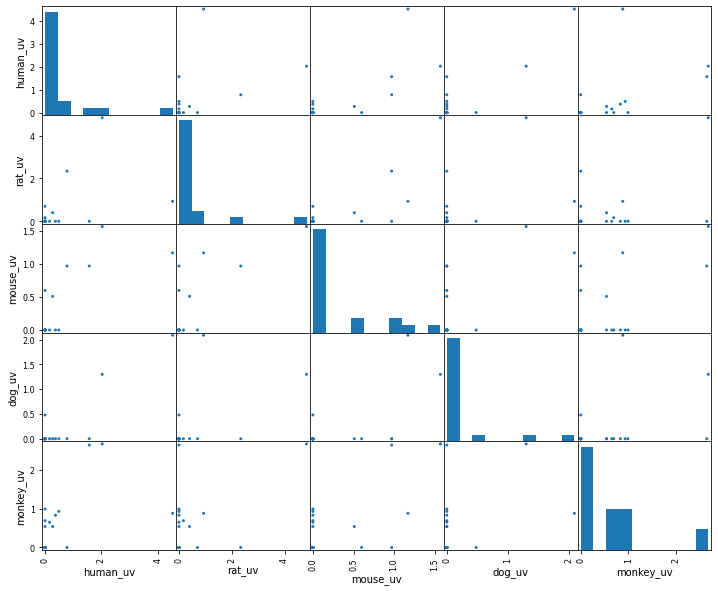

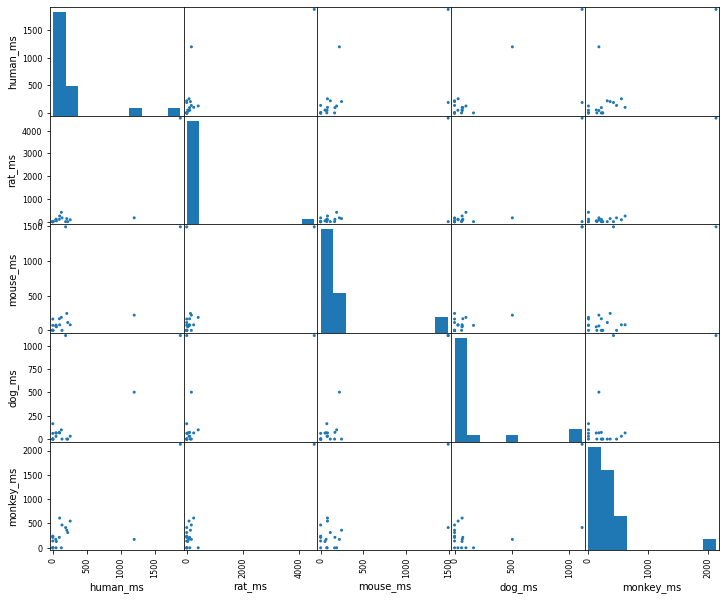

In [16]:
#  Comparing metabolite profile of human to other species with no minimum.

uv_plot = scatter_matrix(uv_df1, alpha=1, figsize=(12,10))
if save_data:
    plt.savefig(pdir / f"{compound}_uv_plot_v1.pdf")

plt.show()

ms_plot = scatter_matrix(ms_df1, alpha=1, figsize=(12,10))
if save_data:
    plt.savefig(pdir / f"{compound}_ms_plot_v1.pdf")

plt.show()

In [17]:
uv_corr = uv_df1.corr()['human_uv']
ms_corr = ms_df1.corr()['human_ms']

if save_data:
    uv_corr.to_csv(pdir / f"{compound}_uv_correlation.csv")
    ms_corr.to_csv(pdir / f"{compound}_ms_correlation.csv")

print("---- UV Correlation -----------")
display(uv_corr)
print("---- Mass Spec Correlation ----")
display(ms_corr)

---- UV Correlation -----------


human_uv     1.000000
rat_uv       0.457348
mouse_uv     0.768287
dog_uv       0.897926
monkey_uv    0.518699
Name: human_uv, dtype: float64

---- Mass Spec Correlation ----


human_ms     1.000000
rat_ms       0.840594
mouse_ms     0.630936
dog_ms       0.714337
monkey_ms    0.792278
Name: human_ms, dtype: float64

In [18]:
df3 = df2.set_index('peak_id')
df3.head()

,mass,mass_shift,modification,ret_time,human_uv,human_ms,rat_uv,rat_ms,mouse_uv,mouse_ms,dog_uv,dog_ms,monkey_uv,monkey_ms
peak_id,,,,,,,,,,,,,,
M259,260.0862,-145.0636,N-dealkylation+Hydroxylation+Desaturation,2.54,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,140.0
M263,264.0917,-141.0581,N-dealkylation,3.62,1.57,220.0,0.0,0.0,0.97,113.0,0.0,0.0,2.64,314.0
M286,287.1279,-118.0219,N-dealkylation,2.34,0.00,53.0,0.0,37.0,0.00,51.0,0.0,65.0,0.00,130.0
M303,304.1105,-101.0393,Unknown,3.02,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,229.0
M328a,329.1085,-76.0413,Unknown,3.72,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.54,239.0


In [19]:
data_cols = [x for x in df3.columns if (x.endswith("_uv") or x.endswith("_ms"))]
for col_name in data_cols:
    df3[f'{col_name}_frac'] = df3[col_name] / df3[col_name].sum()
df3.head()

,mass,mass_shift,modification,ret_time,human_uv,human_ms,rat_uv,rat_ms,mouse_uv,mouse_ms,...,human_uv_frac,human_ms_frac,rat_uv_frac,rat_ms_frac,mouse_uv_frac,mouse_ms_frac,dog_uv_frac,dog_ms_frac,monkey_uv_frac,monkey_ms_frac
peak_id,,,,,,,,,,,,,,,,,,,,,
M259,260.0862,-145.0636,N-dealkylation+Hydroxylation+Desaturation,2.54,0.00,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.021981
M263,264.0917,-141.0581,N-dealkylation,3.62,1.57,220.0,0.0,0.0,0.97,113.0,...,0.153922,0.048288,0.0,0.000000,0.16753,0.025139,0.0,0.000000,0.232394,0.049301
M286,287.1279,-118.0219,N-dealkylation,2.34,0.00,53.0,0.0,37.0,0.00,51.0,...,0.000000,0.011633,0.0,0.006094,0.00000,0.011346,0.0,0.019242,0.000000,0.020411
M303,304.1105,-101.0393,Unknown,3.02,0.00,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.035955
M328a,329.1085,-76.0413,Unknown,3.72,0.00,0.0,0.0,0.0,0.00,0.0,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.047535,0.037526


In [20]:
# Have to figure out what question I'm answering with this.
#    Maybe: How many major metabolites does each species have in common with human?
#    Maybe: Correlation limited to only major metabolites?

frac_cols = [x + "_frac" for x in data_cols]
df4 = df3[frac_cols]
df5 = df4[(df4 > min_abundance).any(1)]
df5

,human_uv_frac,human_ms_frac,rat_uv_frac,rat_ms_frac,mouse_uv_frac,mouse_ms_frac,dog_uv_frac,dog_ms_frac,monkey_uv_frac,monkey_ms_frac
peak_id,,,,,,,,,,
M263,0.153922,0.048288,0.000000,0.000000,0.167530,0.025139,0.000000,0.000000,0.232394,0.049301
M420b,0.000000,0.000000,0.000000,0.000000,0.000000,0.016018,0.124031,0.048845,0.000000,0.000000
M420d,0.199020,0.412643,0.515475,0.749341,0.271157,0.331479,0.335917,0.328597,0.235035,0.334432
M420e,0.000000,0.041484,0.000000,0.000000,0.000000,0.331479,0.000000,0.328597,0.087148,0.065473
M420g,0.444118,0.263389,0.099253,0.027503,0.202073,0.048721,0.540052,0.148905,0.077465,0.027320
M420h,0.000000,0.000000,0.000000,0.000000,0.103627,0.036263,0.000000,0.000000,0.000000,0.000000
M790a,0.076471,0.027656,0.249733,0.067523,0.167530,0.041602,0.000000,0.029307,0.000000,0.000000


In [21]:
frac_uv_features = [f + '_frac' for f in uv_features]
frac_ms_features = [f + '_frac' for f in ms_features]
all_frac_features = frac_uv_features + frac_ms_features
    
uv_frac_df1 = df5[frac_uv_features]
ms_frac_df1 = df5[frac_ms_features]

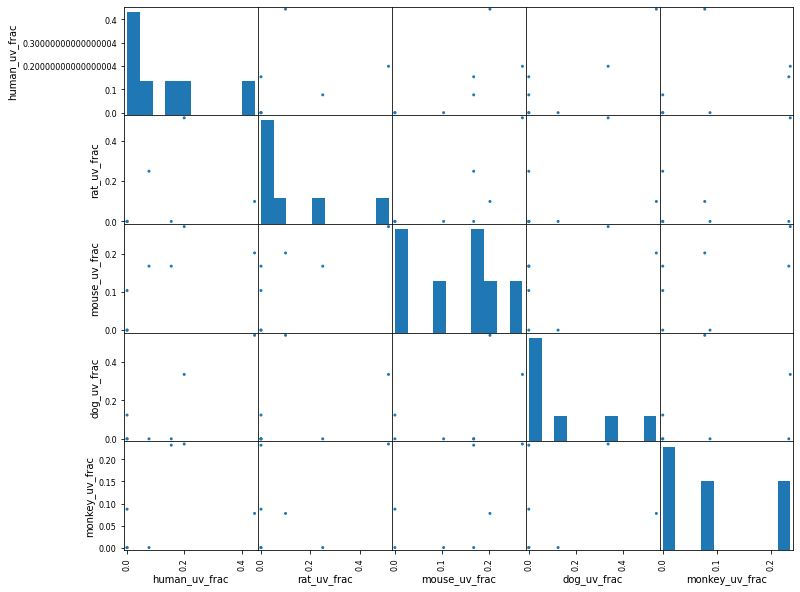

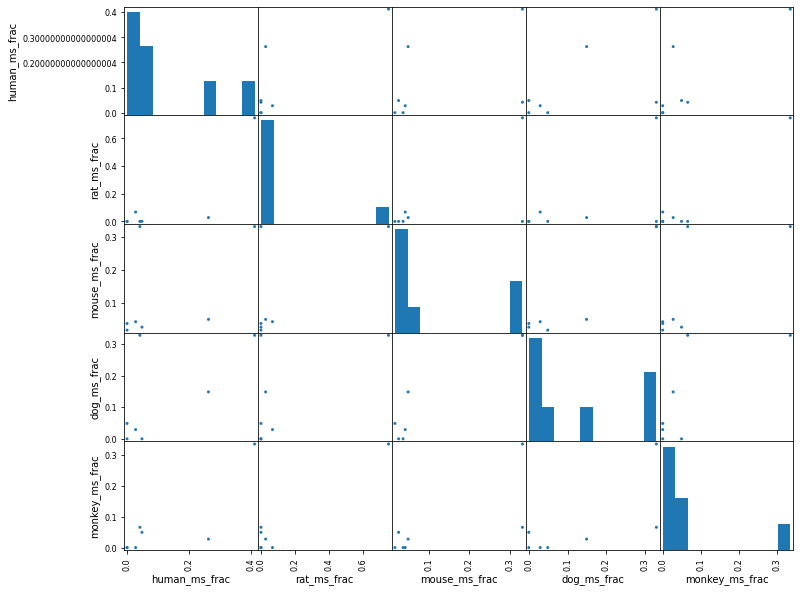

In [22]:
#  Comparing metabolite profile of human to other species with cutoff = min_abundance.

frac_uv_plot = scatter_matrix(uv_frac_df1, alpha=1, figsize=(12,10))
if save_data:
    plt.savefig(pdir / f"{compound}_uv_frac_w-cutoff_plot_v1.pdf")

plt.show()

ms_plot = scatter_matrix(ms_frac_df1, alpha=1, figsize=(12,10))
if save_data:
    plt.savefig(pdir / f"{compound}_ms_frac_w-cutoff_plot_v1.pdf")

plt.show()

In [23]:
frac_uv_corr = uv_frac_df1.corr()['human_uv_frac']
frac_ms_corr = ms_frac_df1.corr()['human_ms_frac']

if save_data:
    uv_corr.to_csv(pdir / f"{compound}_frac_uv_correlation_w-cutoff.csv")
    ms_corr.to_csv(pdir / f"{compound}_frac_ms_correlation_w-cutoff.csv")

print("---- UV Correlation -----------")
display(frac_uv_corr)
print("---- Mass Spec Correlation ----")
display(frac_ms_corr)

---- UV Correlation -----------


human_uv_frac     1.000000
rat_uv_frac       0.303502
mouse_uv_frac     0.691145
dog_uv_frac       0.871212
monkey_uv_frac    0.374253
Name: human_uv_frac, dtype: float64

---- Mass Spec Correlation ----


human_ms_frac     1.000000
rat_ms_frac       0.830485
mouse_ms_frac     0.509916
dog_ms_frac       0.628909
monkey_ms_frac    0.830992
Name: human_ms_frac, dtype: float64